<a href="https://colab.research.google.com/github/Qualot/deep-learning-from-scratch/blob/colab/ch05/TwoLayeresNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.datasets import mnist
from keras.utils import to_categorical
from tqdm import tqdm

In [106]:
np.set_printoptions(linewidth=10000)

#common functions

In [107]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [108]:
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c) #prevents overflow
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [109]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

#Numerical gradient functions

In [110]:
def _numerical_gradient_wo_batch(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]

    #f(x+h)
    x[idx] = tmp_val + h
    fxh1 = f(x)

    #f(x+h)
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val

  return grad

In [111]:
def numerical_gradient(f, x):
  if x.ndim == 1:
    return _numerical_gradient_wo_batch(f, x)

  grad = np.zeros_like(x)
  for key, xvec in enumerate(x):
    grad[key] = _numerical_gradient_wo_batch(f, xvec)

  return grad

#Backpropagation using Computational Graph

In [112]:
class MulLayer:
  def __init__(self,):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    return out

  def backward(self, dout):
    dx = dout * self.y #flip x and y
    dy = dout * self.x

    return dx, dy

In [113]:
class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

In [114]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [115]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

In [116]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    return dx

In [117]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

#Load MNIST and postprocessing (normalize, flatten, one-hot)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   

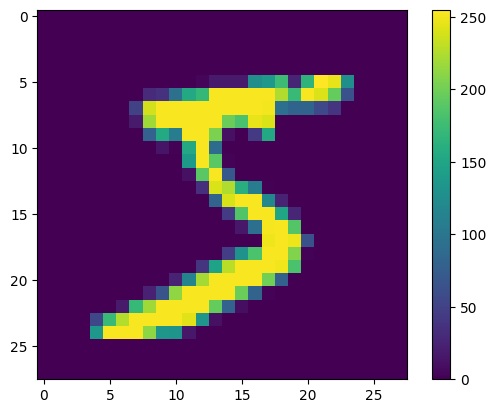

In [118]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train[0])
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [119]:
#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
x_train, t_train, x_test, t_test = [arr.reshape(arr.shape[0], -1) for arr in (x_train, t_train, x_test, t_test)]

#one-hot
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

#TwoLayerNet class

In [120]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    #initialize weights and biasses
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    #layers
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()


  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  #x: input data, t: teacher data
  def loss(self, x, t):
    y = self.predict(x)

    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  #x: input, t: teacher
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

  def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # configuration
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

#Practice part (argmax() for accuracy)

In [121]:
a = np.random.randn(10, 5)
print(a)
b = np.random.randn(10, 5)
print(b)

a = np.argmax(a, axis=1)
b = np.argmax(b, axis=1)
print(a)
print(b)
print(a==b)

[[-1.91740581  0.66221122 -0.03574246 -0.60930201  1.62832527]
 [-0.45811186  1.11982755  0.69003822 -1.17990706  0.59292945]
 [-0.45890792  1.09595561 -0.48045712 -1.27315198  2.24844232]
 [ 0.23503361 -1.32963704  0.72162217  1.50284468 -0.05014598]
 [-1.3968576  -1.42855819  1.45154921 -0.12921563 -0.17716782]
 [ 0.91839395 -0.36834117 -3.41320516  0.01162177  0.00813183]
 [-0.89302358  0.23873803 -0.11193611 -0.81690695 -0.47479379]
 [ 0.94084809  0.21407435 -0.59489931  0.18249811  2.98517629]
 [ 0.45046755  0.26689887  0.36549209 -0.64497415  0.69374649]
 [ 0.80408811  0.52540561  0.74579941  0.67714406 -0.63713003]]
[[-0.61066555  1.06889122 -0.65358903  0.79056596  0.03073874]
 [-1.19666668  1.16196551 -0.0257743  -0.49225195  1.07606434]
 [ 1.20523821 -0.06677709 -0.46946453  1.88926285 -0.05148297]
 [ 1.09029957  0.55917727  0.64783883  1.2007276  -0.02563994]
 [-0.59826907  0.20033945  1.39093973  0.35028045 -1.51906555]
 [-0.72171675  0.9948769   0.40269183 -0.11452562 -0.0

In [122]:
alist = np.random.randn(10, 2)
print(alist)
for key, avec in enumerate(alist):
  print(f"{key} th ... {avec}")

[[-0.80498641  0.1458338 ]
 [-1.59875976 -0.71113883]
 [-0.56203816  1.17499157]
 [-0.86338977  0.58780862]
 [-1.62565216 -1.06122226]
 [-1.06340938  0.27724632]
 [ 0.63080676 -1.64656568]
 [-0.15747769  1.22407607]
 [ 0.19221757 -1.27197604]
 [ 1.56601616  0.01465355]]
0 th ... [-0.80498641  0.1458338 ]
1 th ... [-1.59875976 -0.71113883]
2 th ... [-0.56203816  1.17499157]
3 th ... [-0.86338977  0.58780862]
4 th ... [-1.62565216 -1.06122226]
5 th ... [-1.06340938  0.27724632]
6 th ... [ 0.63080676 -1.64656568]
7 th ... [-0.15747769  1.22407607]
8 th ... [ 0.19221757 -1.27197604]
9 th ... [1.56601616 0.01465355]


#Practice part (TwoLayerNet)

In [123]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [124]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [125]:
t = np.random.rand(100, 10)
#grads = net.numerical_gradient(x, t)

#Practice part (using MNIST)

In [137]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
x_train, t_train, x_test, t_test = [arr.reshape(arr.shape[0], -1) for arr in (x_train, t_train, x_test, t_test)]

#one-hot
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

#Gradient check

In [139]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(f"{key} : {str(diff)}")

W1 : 0.00010308188404318505
b1 : 0.0007842604462021781
W2 : 0.0026195823790665087
b2 : 0.06666666678612665


In [135]:
#hyperparameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in tqdm(range(iters_num)):
  #getting mini batch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #calculating gradient
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch) # high speed using backpropergation

  #updating parameters
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  #recording the learning process
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

  0%|          | 15/10000 [00:00<07:14, 22.97it/s] 

0.18895 0.1865


  6%|▋         | 625/10000 [00:05<02:21, 66.41it/s]

0.09751666666666667 0.0974


 13%|█▎        | 1253/10000 [00:08<00:46, 187.60it/s]

0.09751666666666667 0.0974


 19%|█▊        | 1863/10000 [00:10<00:41, 195.55it/s]

0.09751666666666667 0.0974


 21%|██        | 2067/10000 [00:11<00:25, 305.13it/s]<ipython-input-108-270f26506ae1>:3: RuntimeWarning: invalid value encountered in subtract
  exp_a = np.exp(a-c) #prevents overflow
 25%|██▍       | 2458/10000 [00:12<00:39, 191.48it/s]

0.09871666666666666 0.098


 31%|███       | 3056/10000 [00:14<00:36, 191.47it/s]

0.09871666666666666 0.098


 36%|███▋      | 3625/10000 [00:17<01:06, 96.20it/s] 

0.09871666666666666 0.098


 42%|████▏     | 4226/10000 [00:21<01:29, 64.25it/s]

0.09871666666666666 0.098


 48%|████▊     | 4847/10000 [00:25<00:30, 168.50it/s]

0.09871666666666666 0.098


 55%|█████▍    | 5450/10000 [00:27<00:24, 182.89it/s]

0.09871666666666666 0.098


 61%|██████    | 6051/10000 [00:30<00:21, 181.17it/s]

0.09871666666666666 0.098


 66%|██████▋   | 6639/10000 [00:32<00:18, 186.55it/s]

0.09871666666666666 0.098


 73%|███████▎  | 7260/10000 [00:34<00:14, 187.45it/s]

0.09871666666666666 0.098


 78%|███████▊  | 7831/10000 [00:38<00:31, 69.77it/s]

0.09871666666666666 0.098


 84%|████████▍ | 8449/10000 [00:43<00:16, 94.42it/s]

0.09871666666666666 0.098


 90%|█████████ | 9032/10000 [00:45<00:05, 188.05it/s]

0.09871666666666666 0.098


 96%|█████████▋| 9634/10000 [00:47<00:02, 164.34it/s]

0.09871666666666666 0.098


100%|██████████| 10000/10000 [00:48<00:00, 204.49it/s]


[   0    1    2 ... 9997 9998 9999]
[6.905433040935837, 6.9056525763971175, 6.906095368725451, 6.9045694954490395, 6.90395436628218, 6.903425880192181, 6.901941312794113, 6.89953475435718, 6.898110398853845, 6.8974341208647845, 6.8968873099872186, 6.8974171435026115, 6.892051126459231, 6.884431609479087, 6.889945447637614, 6.880723139514154, 6.8963289811261825, 6.892743405067788, 6.945371814132647, 6.997735783074968, 7.126312139166048, 7.244819247728503, 7.965747664444468, 9.432515162153162, 10.627311648913397, 13.386438343716698, 15.181159067704652, 15.925875299445716, 15.808617093591115, 15.811597951271674, 15.978114622869699, 15.822532852537822, 16.07353162089752, 15.956976390551711, 16.11809565095832, 16.118095647073233, 16.11809565095832, 15.95691469344874, 16.11809565095832, 15.956914693448736, 16.11809565095832, 15.95691469344874, 16.11809565095832, 15.956914693448736, 16.11809565095832, 16.11809565095832, 15.956914693448736, 16.11809565095832, 15.95691469344874, 15.956914693448

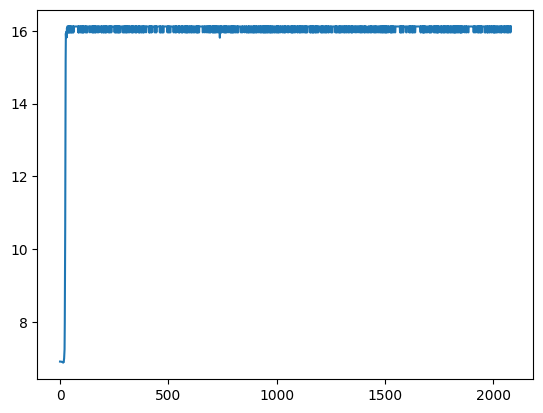

In [136]:
x_points = np.arange(iters_num)
print(x_points)
print(train_loss_list)
plt.plot(x_points, train_loss_list)